In [1]:
import os
import time
import shutil
import tempfile
from glob import glob
import matplotlib.pyplot as plt
from monai.apps import DecathlonDataset
from monai.config import print_config
from monai.data import Dataset, DataLoader, decollate_batch, ImageDataset
from monai.handlers.utils import from_engine
from monai.losses import DiceLoss
from monai.inferers import sliding_window_inference
from monai.metrics import DiceMetric
from monai.networks.nets import SegResNet
from monai.transforms import (
    Activations,
    Activationsd,
    AsDiscrete,
    AsDiscreted,
    Compose,
    Invertd,
    LoadImaged,
    MapTransform,
    NormalizeIntensityd,
    Orientationd,
    RandFlipd,
    RandScaleIntensityd,
    RandShiftIntensityd,
    RandSpatialCropd,
    Spacingd,
    EnsureTyped,
    EnsureChannelFirstd,
    Resized,
    AddChanneld,
    AsChannelFirstd,
    ScaleIntensityRanged
)
from monai.utils import set_determinism

import torch
import pandas as pd
from tqdm import tqdm
#print_config()

In [2]:
image0 = sorted(glob('../../../preparation/scope_mask_slice/sequence_images/*_0000*.nii.gz'))
image1 = sorted(glob('../../../preparation/scope_mask_slice/sequence_images/*_0001*.nii.gz'))
image2 = sorted(glob('../../../preparation/scope_mask_slice/sequence_images/*_0002*.nii.gz'))
label = sorted(glob('../../../preparation/scope_mask_slice/sequence_labels/*.nii.gz'))

In [3]:
label

['../../../preparation/scope_mask_slice/sequence_labels/10005_1000005.nii.gz',
 '../../../preparation/scope_mask_slice/sequence_labels/10021_1000021.nii.gz',
 '../../../preparation/scope_mask_slice/sequence_labels/10032_1000032.nii.gz',
 '../../../preparation/scope_mask_slice/sequence_labels/10043_1000043.nii.gz',
 '../../../preparation/scope_mask_slice/sequence_labels/10048_1000048.nii.gz',
 '../../../preparation/scope_mask_slice/sequence_labels/10078_1000078.nii.gz',
 '../../../preparation/scope_mask_slice/sequence_labels/10079_1000079.nii.gz',
 '../../../preparation/scope_mask_slice/sequence_labels/10085_1000085.nii.gz',
 '../../../preparation/scope_mask_slice/sequence_labels/10117_1000117.nii.gz',
 '../../../preparation/scope_mask_slice/sequence_labels/10118_1000118.nii.gz',
 '../../../preparation/scope_mask_slice/sequence_labels/10164_1000167.nii.gz',
 '../../../preparation/scope_mask_slice/sequence_labels/10168_1000171.nii.gz',
 '../../../preparation/scope_mask_slice/sequence_lab

In [4]:
df_data = pd.DataFrame(list(zip(image0, image1, image2, label)),
              columns=['image0','image1', 'image2', 'label'])

In [5]:
df_data.iloc[1]

image0    ../../../preparation/scope_mask_slice/sequence...
image1    ../../../preparation/scope_mask_slice/sequence...
image2    ../../../preparation/scope_mask_slice/sequence...
label     ../../../preparation/scope_mask_slice/sequence...
Name: 1, dtype: object

In [6]:
list_data = df_data.to_dict('records')

In [7]:
len(list_data)

89

In [8]:
list_data[:500]

[{'image0': '../../../preparation/scope_mask_slice/sequence_images/10005_1000005_0000.nii.gz',
  'image1': '../../../preparation/scope_mask_slice/sequence_images/10005_1000005_0001.nii.gz',
  'image2': '../../../preparation/scope_mask_slice/sequence_images/10005_1000005_0002.nii.gz',
  'label': '../../../preparation/scope_mask_slice/sequence_labels/10005_1000005.nii.gz'},
 {'image0': '../../../preparation/scope_mask_slice/sequence_images/10021_1000021_0000.nii.gz',
  'image1': '../../../preparation/scope_mask_slice/sequence_images/10021_1000021_0001.nii.gz',
  'image2': '../../../preparation/scope_mask_slice/sequence_images/10021_1000021_0002.nii.gz',
  'label': '../../../preparation/scope_mask_slice/sequence_labels/10021_1000021.nii.gz'},
 {'image0': '../../../preparation/scope_mask_slice/sequence_images/10032_1000032_0000.nii.gz',
  'image1': '../../../preparation/scope_mask_slice/sequence_images/10032_1000032_0001.nii.gz',
  'image2': '../../../preparation/scope_mask_slice/sequence_

In [15]:
class ConvertToMultiChannel(MapTransform):
    def __call__(self, data):
        data['image'] = torch.concat([data['image0'],data['image1'],data['image2']], dim=0)
        del data['image0'], data['image1'], data['image2']
        del data['image0_meta_dict'], data['image1_meta_dict'], data['image2_meta_dict'], data['label_meta_dict']
#         print(data['image'].shape)
        return data
        
train_transform = Compose(
    [
        LoadImaged(keys=["image0", "image1","image2", "label"]),
#         AsChannelFirstd(keys=["image0", "image1","image2", "label"]),
#         AddChanneld(keys=["image0", "image1","image2", "label"]),
        EnsureChannelFirstd(keys=["image0", "image1","image2", "label"]),
        EnsureTyped(keys=["image0", "image1","image2", "label"]),
        ConvertToMultiChannel(keys=["image0", "image1","image2"]),
        RandSpatialCropd(keys=["image", "label"], roi_size=[1, 120, 120]),
        Resized(keys=["image", "label"], spatial_size=[240, 240, 16], mode=['area', 'nearest']),
        RandFlipd(keys=["image", "label"], prob=0.5, spatial_axis=0),
        RandFlipd(keys=["image", "label"], prob=0.5, spatial_axis=1),
        RandFlipd(keys=["image", "label"], prob=0.5, spatial_axis=2),
#         ScaleIntensityRanged(keys=["image"], a_min=-200, a_max=50, b_min=0.0, b_max=1.0,clip=True,),
        NormalizeIntensityd(keys="image", nonzero=True, channel_wise=True),
        RandScaleIntensityd(keys="image", factors=0.1, prob=1.0),
        RandShiftIntensityd(keys="image", offsets=0.1, prob=1.0),
    ]
)

valid_transform = Compose(
    [
        LoadImaged(keys=["image0", "image1","image2", "label"]),
#         AsChannelFirstd(keys=["image0", "image1","image2", "label"]),
        AddChanneld(keys=["image0", "image1","image2", "label"]),
        EnsureChannelFirstd(keys=["image0", "image1","image2", "label"]),
        EnsureTyped(keys=["image0", "image1","image2", "label"]),
        ConvertToMultiChannel(keys=["image0", "image1","image2"]),
        Resized(keys=["image", "label"], spatial_size=[512, 512, 24], mode=['area', 'nearest']),
#         ScaleIntensityRanged(keys=["image"], a_min=-200, a_max=50, b_min=0.0, b_max=1.0,clip=True,),
        NormalizeIntensityd(keys="image", nonzero=True, channel_wise=True)
    ]
)

In [16]:
len(list_data)

89

In [17]:
train_ds = Dataset(list_data[:70], transform=train_transform)
train_dl = DataLoader(train_ds, batch_size=1, shuffle=True)

valid_ds = Dataset(list_data[70:], transform=train_transform)
valid_dl = DataLoader(valid_ds, batch_size=1, shuffle=True)

torch.Size([3, 240, 240, 16])
torch.Size([1, 240, 240, 16])


<Figure size 640x480 with 0 Axes>

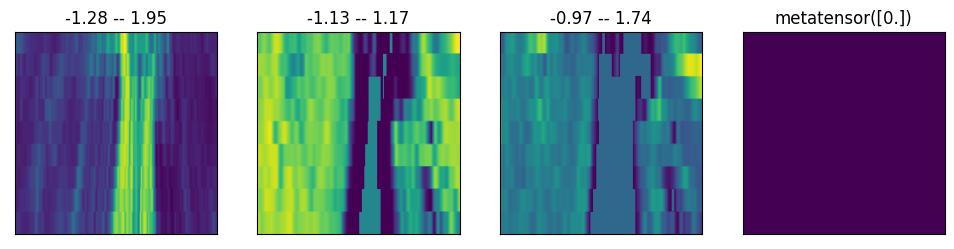

<Figure size 640x480 with 0 Axes>

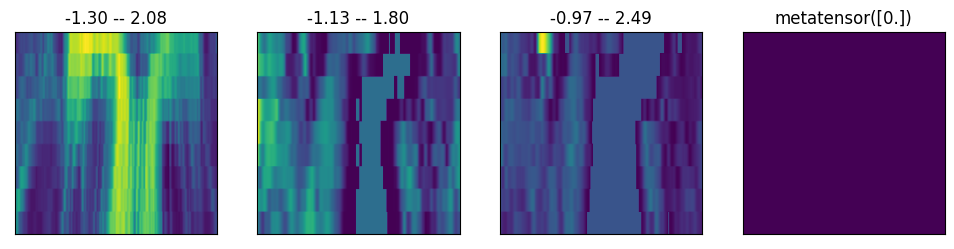

<Figure size 640x480 with 0 Axes>

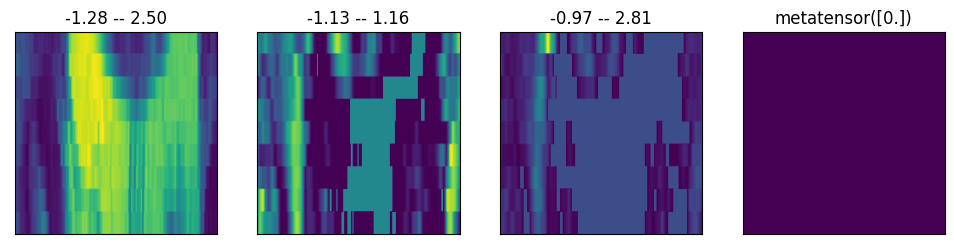

<Figure size 640x480 with 0 Axes>

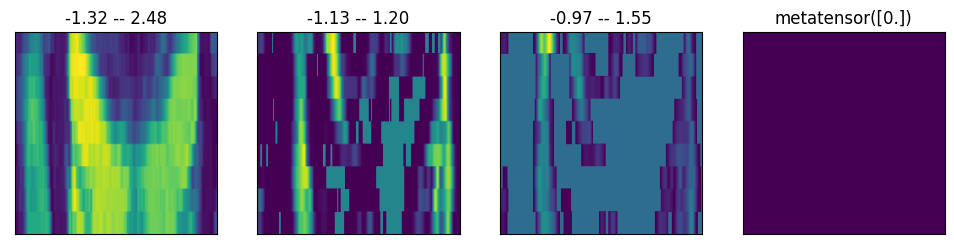

<Figure size 640x480 with 0 Axes>

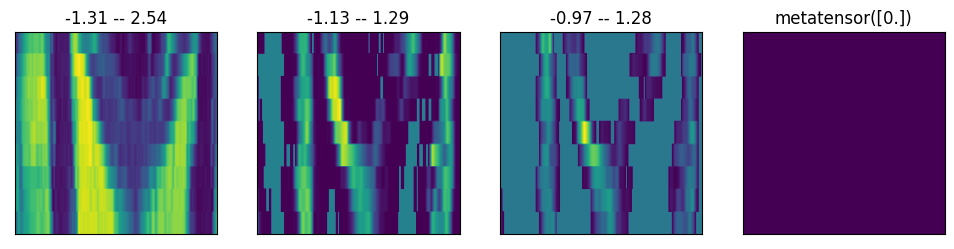

<Figure size 640x480 with 0 Axes>

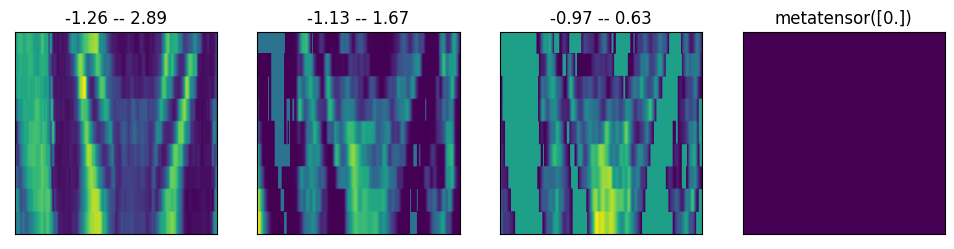

<Figure size 640x480 with 0 Axes>

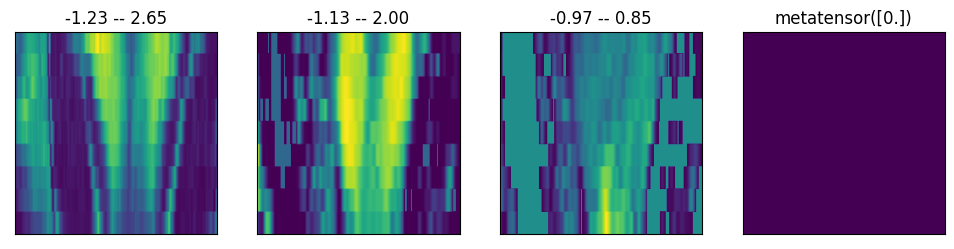

<Figure size 640x480 with 0 Axes>

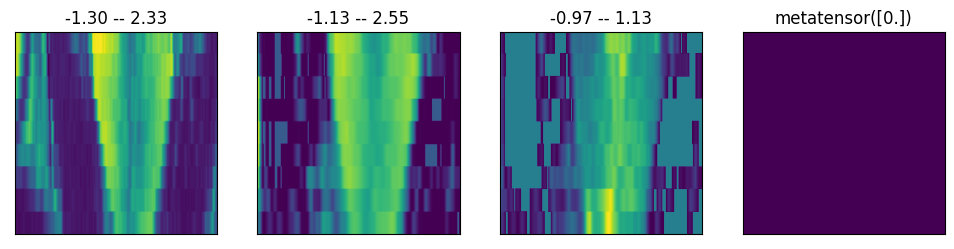

<Figure size 640x480 with 0 Axes>

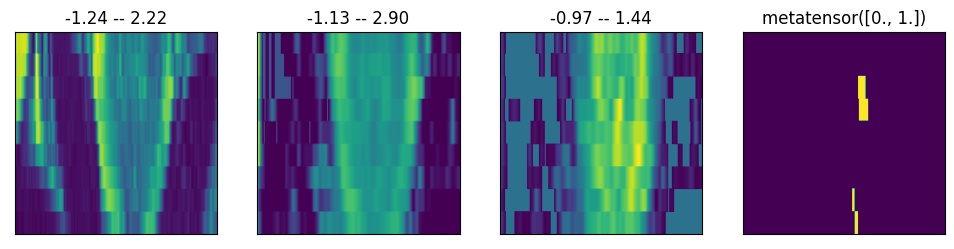

In [18]:
one_batch = train_ds[1]
print(one_batch['image'].shape)
print(one_batch['label'].shape)
for i in range(1,10):
    plt.figure()
    image = one_batch['image']
    label = one_batch['label']
    plt.figure(figsize=(12,6))
    plt.subplot(141), plt.imshow(image[0,:,:,i]), plt.title(f"{image[0,:,:,i].min():.2f} -- {image[0,:,:,i].max():.2f}"), plt.xticks([]), plt.yticks([])
    plt.subplot(142), plt.imshow(image[1,:,:,i]), plt.title(f"{image[1,:,:,i].min():.2f} -- {image[1,:,:,i].max():.2f}"), plt.xticks([]), plt.yticks([])
    plt.subplot(143), plt.imshow(image[2,:,:,i]), plt.title(f"{image[2,:,:,i].min():.2f} -- {image[2,:,:,i].max():.2f}"), plt.xticks([]), plt.yticks([])
    plt.subplot(144), plt.imshow(label[0,:,:,i]), plt.title(label[0,:,:,i].unique()), plt.xticks([]), plt.yticks([])

In [19]:
max_epochs = 300
val_interval = 1
VAL_AMP = True

# standard PyTorch program style: create SegResNet, DiceLoss and Adam optimizer
device = torch.device("cuda:0")
model = SegResNet(
    blocks_down=[1, 2, 2, 4],
    blocks_up=[1, 1, 1],
    init_filters=16,
    in_channels=3,
    out_channels=3,
    dropout_prob=0.2,
).to(device)
loss_function = DiceLoss(smooth_nr=0, smooth_dr=1e-5, squared_pred=True, to_onehot_y=True)
optimizer = torch.optim.Adam(model.parameters(), 1e-4, weight_decay=1e-5)
lr_scheduler = torch.optim.lr_scheduler.CosineAnnealingLR(optimizer, T_max=max_epochs)

dice_metric = DiceMetric(include_background=False, reduction="mean")
dice_metric_batch = DiceMetric(include_background=False, reduction="mean_batch")

post_trans = Compose([Activations(sigmoid=True), AsDiscrete(threshold=0.5)])

# define inference method
def inference(input):
    def _compute(input):
        return sliding_window_inference(
            inputs=input,
            roi_size=(240, 240, 16),
            sw_batch_size=1,
            predictor=model,
            overlap=0.5,
        )

    if VAL_AMP:
        with torch.cuda.amp.autocast():
            return _compute(input)
    else:
        return _compute(input)


# use amp to accelerate training
scaler = torch.cuda.amp.GradScaler()
# enable cuDNN benchmark
torch.backends.cudnn.benchmark = True

In [ ]:
best_metric = -1
best_metric_epoch = -1
best_metrics_epochs_and_time = [[], [], []]
epoch_loss_values = []
metric_values = []
metric_values_gland = []
metric_values_lesion = []
metric_values_et = []

total_start = time.time()
for epoch in range(max_epochs):
    epoch_start = time.time()
    print("-" * 10)
    print(f"epoch {epoch + 1}/{max_epochs}")
    model.train()
    epoch_loss = 0
    step = 0
    for batch_data in (pbar := tqdm(train_dl, total=len(train_dl))):
        step_start = time.time()
        step += 1
        inputs, labels = (
            batch_data["image"].to(device),
            batch_data["label"].to(device),
        )
        optimizer.zero_grad()
        with torch.cuda.amp.autocast():
            outputs = model(inputs)
            loss = loss_function(outputs, labels)
        scaler.scale(loss).backward()
        scaler.step(optimizer)
        scaler.update()
        epoch_loss += loss.item()
        pbar.set_description(f"current loss {loss.item():.4f}")
        #print(
        #    f"{step}/{len(train_ds) // train_dl.batch_size}"
        #    f", train_loss: {loss.item():.4f}"
        #    f", step time: {(time.time() - step_start):.4f}"
        #)
    lr_scheduler.step()
    epoch_loss /= step
    epoch_loss_values.append(epoch_loss)
    print(f"epoch {epoch + 1} average loss: {epoch_loss:.4f}")

    if (epoch + 1) % val_interval == 0:
        model.eval()
        with torch.no_grad():
            for val_data in valid_dl:
                val_inputs, val_labels = (
                    val_data["image"].to(device),
                    val_data["label"].to(device),
                )
                val_outputs = inference(val_inputs)
                val_outputs = [post_trans(i) for i in decollate_batch(val_outputs)]
                dice_metric(y_pred=val_outputs, y=val_labels)
                dice_metric_batch(y_pred=val_outputs, y=val_labels)

            metric = dice_metric.aggregate().item()
            metric_values.append(metric)
            metric_batch = dice_metric_batch.aggregate()
            metric_gland = metric_batch[0].item()
            metric_values_gland.append(metric_gland)
            metric_lesion = metric_batch[1].item()
            metric_values_lesion.append(metric_lesion)
            dice_metric.reset()
            dice_metric_batch.reset()

            if metric > best_metric:
                best_metric = metric
                best_metric_epoch = epoch + 1
                best_metrics_epochs_and_time[0].append(best_metric)
                best_metrics_epochs_and_time[1].append(best_metric_epoch)
                best_metrics_epochs_and_time[2].append(time.time() - total_start)
                #torch.save(
                #    model.state_dict(),
                #    os.path.join(root_dir, "best_metric_model.pth"),
                #)
                #print("saved new best metric model")
            print(
                f"current epoch: {epoch + 1} current mean dice: {metric:.4f}"
                f" gland: {metric_gland:.4f} lesion: {metric_lesion:.4f}"
                f"\nbest mean dice: {best_metric:.4f}"
                f" at epoch: {best_metric_epoch}"
            )
    print(f"time consuming of epoch {epoch + 1} is: {(time.time() - epoch_start):.4f}")
total_time = time.time() - total_start

----------
epoch 1/300


current loss 0.7897: 100%|████████████████████████████████████████████████████████████████████████████| 70/70 [01:09<00:00,  1.01it/s]


epoch 1 average loss: 0.7783
current epoch: 1 current mean dice: 0.0145 gland: 0.0145 lesion: 0.0000
best mean dice: 0.0145 at epoch: 1
time consuming of epoch 1 is: 82.1955
----------
epoch 2/300


current loss 0.5391: 100%|████████████████████████████████████████████████████████████████████████████| 70/70 [01:09<00:00,  1.00it/s]


epoch 2 average loss: 0.6903
current epoch: 2 current mean dice: 0.0360 gland: 0.0360 lesion: 0.0000
best mean dice: 0.0360 at epoch: 2
time consuming of epoch 2 is: 82.1326
----------
epoch 3/300


current loss 0.6419: 100%|████████████████████████████████████████████████████████████████████████████| 70/70 [01:10<00:00,  1.00s/it]


epoch 3 average loss: 0.6498
current epoch: 3 current mean dice: 0.0166 gland: 0.0166 lesion: 0.0000
best mean dice: 0.0360 at epoch: 2
time consuming of epoch 3 is: 83.4001
----------
epoch 4/300


current loss 0.6629: 100%|████████████████████████████████████████████████████████████████████████████| 70/70 [01:09<00:00,  1.01it/s]


epoch 4 average loss: 0.6379
current epoch: 4 current mean dice: 0.0238 gland: 0.0238 lesion: 0.0000
best mean dice: 0.0360 at epoch: 2
time consuming of epoch 4 is: 82.8286
----------
epoch 5/300


current loss 0.4573: 100%|████████████████████████████████████████████████████████████████████████████| 70/70 [01:12<00:00,  1.04s/it]


epoch 5 average loss: 0.6093
current epoch: 5 current mean dice: 0.0541 gland: 0.0541 lesion: 0.0000
best mean dice: 0.0541 at epoch: 5
time consuming of epoch 5 is: 86.0945
----------
epoch 6/300


current loss 0.6601: 100%|████████████████████████████████████████████████████████████████████████████| 70/70 [01:09<00:00,  1.01it/s]


epoch 6 average loss: 0.6073
current epoch: 6 current mean dice: 0.0227 gland: 0.0227 lesion: 0.0000
best mean dice: 0.0541 at epoch: 5
time consuming of epoch 6 is: 82.5280
----------
epoch 7/300


current loss 0.5560: 100%|████████████████████████████████████████████████████████████████████████████| 70/70 [01:00<00:00,  1.15it/s]


epoch 7 average loss: 0.5935
current epoch: 7 current mean dice: 0.0413 gland: 0.0413 lesion: 0.0000
best mean dice: 0.0541 at epoch: 5
time consuming of epoch 7 is: 71.9862
----------
epoch 8/300


current loss 0.5215: 100%|████████████████████████████████████████████████████████████████████████████| 70/70 [00:59<00:00,  1.17it/s]


epoch 8 average loss: 0.5892
current epoch: 8 current mean dice: 0.0152 gland: 0.0152 lesion: 0.0000
best mean dice: 0.0541 at epoch: 5
time consuming of epoch 8 is: 70.4088
----------
epoch 9/300


current loss 0.6243: 100%|████████████████████████████████████████████████████████████████████████████| 70/70 [01:05<00:00,  1.07it/s]


epoch 9 average loss: 0.5760
current epoch: 9 current mean dice: 0.0173 gland: 0.0173 lesion: 0.0000
best mean dice: 0.0541 at epoch: 5
time consuming of epoch 9 is: 78.7653
----------
epoch 10/300


current loss 0.6775: 100%|████████████████████████████████████████████████████████████████████████████| 70/70 [01:01<00:00,  1.14it/s]


epoch 10 average loss: 0.5866
current epoch: 10 current mean dice: 0.0303 gland: 0.0303 lesion: 0.0000
best mean dice: 0.0541 at epoch: 5
time consuming of epoch 10 is: 72.9462
----------
epoch 11/300


current loss 0.5763:   9%|██████▌                                                                      | 6/70 [00:03<00:56,  1.13it/s]

In [ ]:
metric_values_gland = []
metric_values_lesion = []
model.eval()
with torch.no_grad():
    for val_data in valid_dl:
        val_inputs, val_labels = (
            val_data["image"].to(device),
            val_data["label"].to(device),
        )
        val_outputs = inference(val_inputs)
        val_outputs = [post_trans(i) for i in decollate_batch(val_outputs)]
        dice_metric(y_pred=val_outputs, y=val_labels)
        dice_metric_batch(y_pred=val_outputs, y=val_labels)

    metric = dice_metric.aggregate().item()
    metric_values.append(metric)
    metric_batch = dice_metric_batch.aggregate()
    metric_gland = metric_batch[0].item()
    metric_values_gland.append(metric_gland)
    metric_lesion = metric_batch[1].item()
    metric_values_lesion.append(metric_lesion)
    dice_metric.reset()
    dice_metric_batch.reset()


In [ ]:
one_batch = ds[2]
for i in range(0,16):
    plt.figure()
    image = one_batch['image'][0]
    label = one_batch['label'][0]
    predict = model(one_batch['image'].unsqueeze(0).to('cuda'))[0][0]
    plt.subplot(131), plt.imshow(image[:,:,i]), plt.title(f"{image[:,:,i].min():.2f} - {image[:,:,i].max():.2f}")
    plt.subplot(132), plt.imshow(label[:,:,i]), plt.title(label[:,:,i].unique())
    plt.subplot(133), plt.imshow(predict[:,:,i].cpu().detach().numpy()>0), 